# Datasets from the NormA journal paper(WADI)

- Paper: https://doi.org/10.1007/s00778-021-00655-8
- Website: https://helios2.mi.parisdescartes.fr/~themisp/norma/

In [67]:
from typing import List
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from config import data_raw_folder, data_processed_folder

from timeeval import Datasets, DatasetManager
from timeeval.datasets import DatasetAnalyzer, DatasetRecord

In [68]:
plt.rcParams["figure.figsize"] = (20, 10)

In [69]:
source_folder = Path(data_raw_folder) / "NormA" / "selected_datasets"
target_folder = Path(data_processed_folder)

print(f"Looking for source datasets in {Path(source_folder).absolute()} and\nsaving processed datasets in {Path(target_folder).absolute()}")

Looking for source datasets in /home/projects/akita/data/benchmark-data/data-raw/NormA/selected_datasets and
saving processed datasets in /home/projects/akita/data/benchmark-data/data-processed


In [70]:
# shared by all datasets
dataset_collection_name = "NormA"
input_type = "univariate"
datetime_index = False
split_at = None
train_is_normal = False
train_type = "unsupervised"

# create target directory
dataset_subfolder = Path(input_type) / dataset_collection_name
target_subfolder = target_folder / dataset_subfolder
target_subfolder.mkdir(parents=True, exist_ok=True)
print(f"Created directories {target_subfolder}")

dm = DatasetManager(target_folder)

# load discord information for real datasets
ANOMALY_INFORMATION = "anomaly_information.csv"
df_anomaly = pd.read_csv(source_folder / ANOMALY_INFORMATION)
df_anomaly = df_anomaly.set_index("dataset")

Created directories /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA


In [77]:
def prepare_dataset(filepath: Path, dataset_name: str, dataset_type: str) -> pd.DataFrame:
    if dataset_type == "synthetic":
        discord_positions = np.genfromtxt(filepath.parent / f"{dataset_name}_Annotations.txt", delimiter=",")
        discord_length = int(filepath.stem.split("_")[4].strip())
        length = None
    else:
        discord_positions = df_anomaly.loc[dataset_name, "anomaly_indices"].split(";")
        discord_positions = np.array([int(i) for i in discord_positions])
        discord_length = df_anomaly.loc[dataset_name, "anomaly_length"]
        length = df_anomaly.loc[dataset_name, "length"]
    anomalies = []
    for idx in discord_positions:
        anomalies.append(np.arange(idx, idx+discord_length))

    df = pd.read_csv(filepath, header=None)
    df.index.name = "timestamp"
    df.columns = ["value"]
    if length is not None:
        df = df.iloc[:length]

    # insert labels
    df["is_anomaly"] = 0
    for anomaly in anomalies:
        df.loc[anomaly, "is_anomaly"] = 1

    df = df.reset_index()
    return df

In [78]:
time_series_paths = [f for f in source_folder.glob("*.ts") if f.stem != ANOMALY_INFORMATION.split(".")[0]]
for filepath in time_series_paths:
    dataset_name = filepath.stem
    print(f"Processing dataset {dataset_name}")
    
    test_filename = f"{dataset_name}.test.csv"
    test_path = dataset_subfolder / test_filename
    target_test_filepath = target_subfolder / test_filename
    target_meta_filepath = target_subfolder / f"{dataset_name}.metadata.json"

    dataset_type = "real"
    if dataset_name.startswith("SinusRW"):
        dataset_type = "synthetic"

    # prepare test dataset
    df_test = prepare_dataset(filepath, dataset_name, dataset_type)
    df_test.to_csv(target_test_filepath, index=False)
    print("  written test dataset")

    # analyze test dataset
    da = DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=False, df=df_test)
    meta = da.metadata
    da.save_to_json(target_meta_filepath, overwrite=True)
    print("  analyzed and written test dataset metadata")

    dm.add_dataset(DatasetRecord(
          collection_name=dataset_collection_name,
          dataset_name=dataset_name,
          train_path=None,
          test_path=test_path,
          dataset_type=dataset_type,
          datetime_index=datetime_index,
          split_at=split_at,
          train_type=train_type,
          train_is_normal=train_is_normal,
          input_type=input_type,
          length=meta.length,
          dimensions=meta.dimensions,
          contamination=meta.contamination,
          num_anomalies=meta.num_anomalies,
          min_anomaly_length=meta.anomaly_length.min,
          median_anomaly_length=meta.anomaly_length.median,
          max_anomaly_length=meta.anomaly_length.max,
          mean=meta.mean,
          stddev=meta.stddev,
          trend=meta.trend,
          stationarity=meta.get_stationarity_name(),
          period_size=np.nan
    ))
    print(f"... processed dataset {dataset_name}")

Processing dataset SinusRW_Length_196000_AnomalyL_1600_AnomalyN_60_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_196000_AnomalyL_1600_AnomalyN_60_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_196000_AnomalyL_1600_AnomalyN_60_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
[('NormA', 'Discords_patient_respiration2') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/Discords_patient_respiration2.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_196000_AnomalyL_1600_AnomalyN_60_NoisePerc_0
Processing dataset Discords_patient_respiration2
  written test dataset
  analyzed and written test dataset metadata
... processed dataset Discords_patient_respiration2
Processing dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_10
  written test dataset


[('NormA', 'SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_10') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_10.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_10
Processing dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_20
  written test dataset


[('NormA', 'SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_20') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_20.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_20
Processing dataset SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_NoisePerc_0
Processing dataset Discords_marotta_valve_tek_17
  written test dataset


[('NormA', 'Discords_marotta_valve_tek_17') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/Discords_marotta_valve_tek_17.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset Discords_marotta_valve_tek_17
Processing dataset SinusRW_Length_116000_AnomalyL_200_AnomalyN_80_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_116000_AnomalyL_200_AnomalyN_80_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_116000_AnomalyL_200_AnomalyN_80_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_116000_AnomalyL_200_AnomalyN_80_NoisePerc_0
Processing dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_15
  written test dataset


[('NormA', 'SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_15') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_15.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_15
Processing dataset SinusRW_Length_148000_AnomalyL_800_AnomalyN_60_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_148000_AnomalyL_800_AnomalyN_60_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_148000_AnomalyL_800_AnomalyN_60_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_148000_AnomalyL_800_AnomalyN_60_NoisePerc_0
Processing dataset SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_NoisePerc_0
Processing dataset SinusRW_Length_124000_AnomalyL_400_AnomalyN_60_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_124000_AnomalyL_400_AnomalyN_60_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_124000_AnomalyL_400_AnomalyN_60_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_124000_AnomalyL_400_AnomalyN_60_NoisePerc_0
Processing dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_5
  written test dataset


[('NormA', 'SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_5') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_5.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_5
Processing dataset SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.
[('NormA', 'Discords_annsgun') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/Discords_annsgun.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_NoisePerc_0
Processing dataset Discords_annsgun
  written test dataset
  analyzed and written test dataset metadata
... processed dataset Discords_annsgun
Processing dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_25
  written test dataset


[('NormA', 'SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_25') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_25.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_25
Processing dataset SinusRW_Length_120000_AnomalyL_200_AnomalyN_100_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_120000_AnomalyL_200_AnomalyN_100_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_120000_AnomalyL_200_AnomalyN_100_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_120000_AnomalyL_200_AnomalyN_100_NoisePerc_0
Processing dataset Discords_patient_respiration1
  written test dataset


[('NormA', 'Discords_patient_respiration1') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/Discords_patient_respiration1.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset Discords_patient_respiration1
Processing dataset Discords_marotta_valve_tek_16
  written test dataset


[('NormA', 'Discords_marotta_valve_tek_16') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/Discords_marotta_valve_tek_16.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset Discords_marotta_valve_tek_16
Processing dataset Discords_marotta_valve_tek_14
  written test dataset


[('NormA', 'Discords_marotta_valve_tek_14') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/Discords_marotta_valve_tek_14.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset Discords_marotta_valve_tek_14
Processing dataset Discords_dutch_power_demand
  written test dataset


[('NormA', 'Discords_dutch_power_demand') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/Discords_dutch_power_demand.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset Discords_dutch_power_demand
Processing dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_0
  written test dataset


[('NormA', 'SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_0') (test)] /home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_0.metadata.json already exists, but 'overwrite' was specified! Ignoring existing contents.


  analyzed and written test dataset metadata
... processed dataset SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_NoisePerc_0


In [79]:
dm.save()

In [80]:
dm.refresh()
dm.df().loc[(slice(dataset_collection_name,dataset_collection_name), slice(None))]

train_path  \
collection_name dataset_name                                                    
NormA           Discords_annsgun                                          NaN   
                Discords_dutch_power_demand                               NaN   
                Discords_marotta_valve_tek_14                             NaN   
                Discords_marotta_valve_tek_16                             NaN   
                Discords_marotta_valve_tek_17                             NaN   
                Discords_patient_respiration1                             NaN   
                Discords_patient_respiration2                             NaN   
                SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_...        NaN   
                SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_...        NaN   
                SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_...        NaN   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...        NaN   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...        NaN   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...        NaN   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...        NaN   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...        NaN   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...        NaN   
                SinusRW_Length_116000_AnomalyL_200_AnomalyN_80_...        NaN   
                SinusRW_Length_120000_AnomalyL_200_AnomalyN_100...        NaN   
                SinusRW_Length_124000_AnomalyL_400_AnomalyN_60_...        NaN   
                SinusRW_Length_148000_AnomalyL_800_AnomalyN_60_...        NaN   
                SinusRW_Length_196000_AnomalyL_1600_AnomalyN_60...        NaN   

                                                                                                            test_path  \
collection_name dataset_name                                                                                            
NormA           Discords_annsgun                                           univariate/NormA/Discords_annsgun.test.csv   
                Discords_dutch_power_demand                         univariate/NormA/Discords_dutch_power_demand.t...   
                Discords_marotta_valve_tek_14                       univariate/NormA/Discords_marotta_valve_tek_14...   
                Discords_marotta_valve_tek_16                       univariate/NormA/Discords_marotta_valve_tek_16...   
                Discords_marotta_valve_tek_17                       univariate/NormA/Discords_marotta_valve_tek_17...   
                Discords_patient_respiration1                       univariate/NormA/Discords_patient_respiration1...   
                Discords_patient_respiration2                       univariate/NormA/Discords_patient_respiration2...   
                SinusRW_Length_104000_AnomalyL_200_AnomalyN_20_...  univariate/NormA/SinusRW_Length_104000_Anomaly...   
                SinusRW_Length_106000_AnomalyL_100_AnomalyN_60_...  univariate/NormA/SinusRW_Length_106000_Anomaly...   
                SinusRW_Length_108000_AnomalyL_200_AnomalyN_40_...  univariate/NormA/SinusRW_Length_108000_Anomaly...   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...  univariate/NormA/SinusRW_Length_112000_Anomaly...   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...  univariate/NormA/SinusRW_Length_112000_Anomaly...   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...  univariate/NormA/SinusRW_Length_112000_Anomaly...   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...  univariate/NormA/SinusRW_Length_112000_Anomaly...   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...  univariate/NormA/SinusRW_Length_112000_Anomaly...   
                SinusRW_Length_112000_AnomalyL_200_AnomalyN_60_...  univariate/NormA/SinusRW_Length_112000_Anomaly...   
                SinusRW_L

## Exploration

In [9]:
ANOMALY_INFORMATION = "anomaly_information.csv"
df_anomaly = pd.read_csv(source_folder / ANOMALY_INFORMATION)
df_anomaly = df_anomaly.set_index("dataset")
df_anomaly

,length,domain,anomalies,anomaly_indices,anomaly_length
dataset,,,,,
Discords_annsgun,2000,Video recording,1,300,150
Discords_marotta_valve_tek_16,5000,Space Engineering,1,4400,128
Discords_marotta_valve_tek_17,5000,Space Engineering,1,2100,128
Discords_marotta_valve_tek_14,5000,Space Engineering,2,1100;1500,128
Discords_patient_respiration1,6500,Pneumology,1,800;5000,100
Discords_patient_respiration2,4000,Pneumology,1,3000;3400,150
Discords_dutch_power_demand,35040,Energy consumption study,4,11453;33993;7786;12639,800


In [66]:
time_series_paths = [f for f in source_folder.glob("*.ts") if f.stem != ANOMALY_INFORMATION.split(".")[0]]

In [46]:
filepath = time_series_paths[-8]
dataset_name = filepath.stem
print(f"{dataset_name=}")

dataset_type = "real"
if dataset_name.startswith("SinusRW"):
    dataset_type = "synthetic"
print(f"{dataset_type=}")

if dataset_type == "synthetic":
    discord_positions = np.genfromtxt(filepath.parent / f"{dataset_name}_Annotations.txt", delimiter=",")
    discord_length = int(filepath.stem.split("_")[4].strip())
    length = None
else:
    discord_positions = df_anomaly.loc[dataset_name, "anomaly_indices"].split(";")
    discord_positions = np.array([int(i) for i in discord_positions])
    discord_length = df_anomaly.loc[dataset_name, "anomaly_length"]
    length = df_anomaly.loc[dataset_name, "length"]
print(f"{discord_positions=}, {discord_length=}")
anomalies = []
for idx in discord_positions:
    anomalies.append(np.arange(idx, idx+discord_length))

df = pd.read_csv(filepath, header=None)
if length is not None:
    df = df.iloc[:length]

df.index.name = "timestamp"
df.columns = ["value"]

# insert labels
df["is_anomaly"] = 0
for anomaly in anomalies:
    df.loc[anomaly, "is_anomaly"] = 1

df

dataset_name='Discords_annsgun'
dataset_type='real'
discord_positions=array([300]), discord_length=150


,value,is_anomaly
timestamp,,
0,196.37467,0
1,196.49124,0
2,196.79989,0
3,197.17570,0
4,197.87943,0
...,...,...
1995,266.45147,0
1996,269.02330,0
1997,271.33349,0


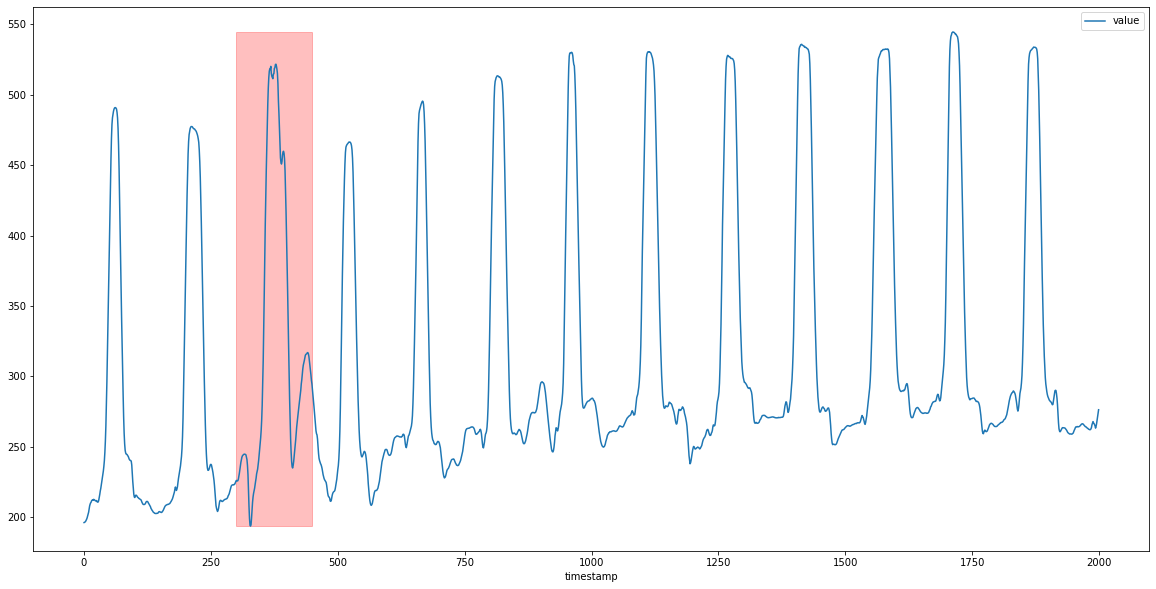

In [48]:
df_tmp = df.iloc[:, :-1]
df_tmp.plot()
s = df["is_anomaly"].diff()
y_max = df_tmp.max().max()
y_min = df_tmp.min().min()
for begin, end in zip(s[s == -1].index, s[s == 1].index):
    plt.gca().add_patch(matplotlib.patches.Rectangle((begin, y_min), end - begin, y_max - y_min, color="red", alpha=0.25))
#plt.gca().set_xlim(2500, 4500)
#plt.savefig("SinusRW-clip.png")
plt.show()

dataset=PosixPath('/home/projects/akita/data/benchmark-data/data-processed/univariate/NormA/Discords_dutch_power_demand.test.csv')


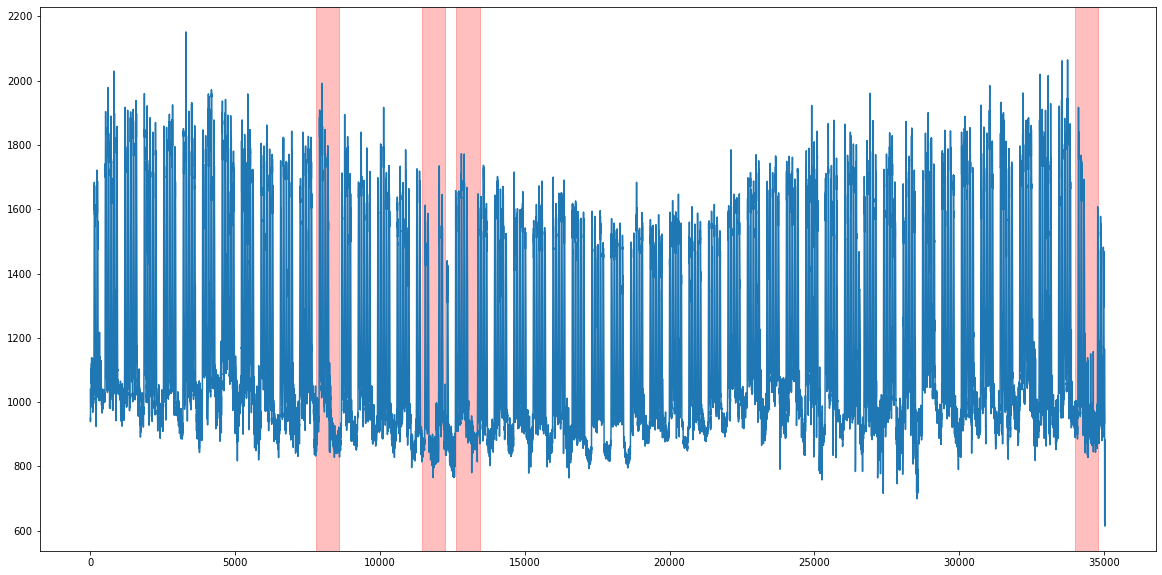

In [63]:
#dataset = target_folder / dataset_subfolder / "Discords_marotta_valve_tek_16.test.csv"
#dataset = target_folder / dataset_subfolder / "Discords_marotta_valve_tek_17.test.csv"
#dataset = target_folder / dataset_subfolder / "Discords_marotta_valve_tek_14.test.csv"
#dataset = target_folder / dataset_subfolder / "Discords_patient_respiration2.test.csv"
dataset = target_folder / dataset_subfolder / "Discords_dutch_power_demand.test.csv"
#dataset = target_folder / dataset_subfolder / "Discords_annsgun.test.csv"
print(f"{dataset=}")
df_tmp = pd.read_csv(dataset)
df_tmp.iloc[:, 1].plot()
s = df_tmp["is_anomaly"].diff()
y_max = df_tmp.max().max()
y_min = df_tmp.min().min()
for begin, end in zip(s[s == -1].index, s[s == 1].index):
    plt.gca().add_patch(matplotlib.patches.Rectangle((begin, y_min), end - begin, y_max - y_min, color="red", alpha=0.25))
#plt.gca().set_xlim(2000, 6000)
plt.show()